In [2]:
import pandas as pd

returns_df = pd.read_csv('data/asset_returns.csv')
funding_df = pd.read_pickle('data/funding_rate_history.pkl')

btc_funding_raw = funding_df['binance']['BTC/USDT:USDT']
btc_funding_df = pd.DataFrame(btc_funding_raw)
btc_funding_df['datetime'] = pd.to_datetime(btc_funding_df['datetime'], utc=True)
btc_funding_df = btc_funding_df[['datetime', 'fundingRate']]

returns_df['datetime'] = pd.to_datetime(returns_df['datetime'], utc=True)
btc_returns_df = returns_df[['datetime', 'BTCUSDT']].rename(columns={'BTCUSDT': 'btc_return'})

merged_df = pd.merge_asof(
    btc_funding_df.sort_values('datetime'),
    btc_returns_df.sort_values('datetime'),
    on='datetime',
    direction='nearest',
    tolerance=pd.Timedelta('1h')
)

merged_df.dropna(inplace=True)
merged_df.to_csv('data/merged_btc_funding_returns.csv', index=False)

In [3]:
max_lag = 24
lagged_correlations = {}

for lag in range(1, max_lag + 1):
    merged_df[f'return_t+{lag}'] = merged_df['btc_return'].shift(-lag)
    corr = merged_df['fundingRate'].corr(merged_df[f'return_t+{lag}'])
    lagged_correlations[lag] = corr

lagged_corr_df = pd.Series(lagged_correlations).to_frame('correlation')
lagged_corr_df.index.name = 'Lag (h)'
lagged_corr_df.reset_index(inplace=True)

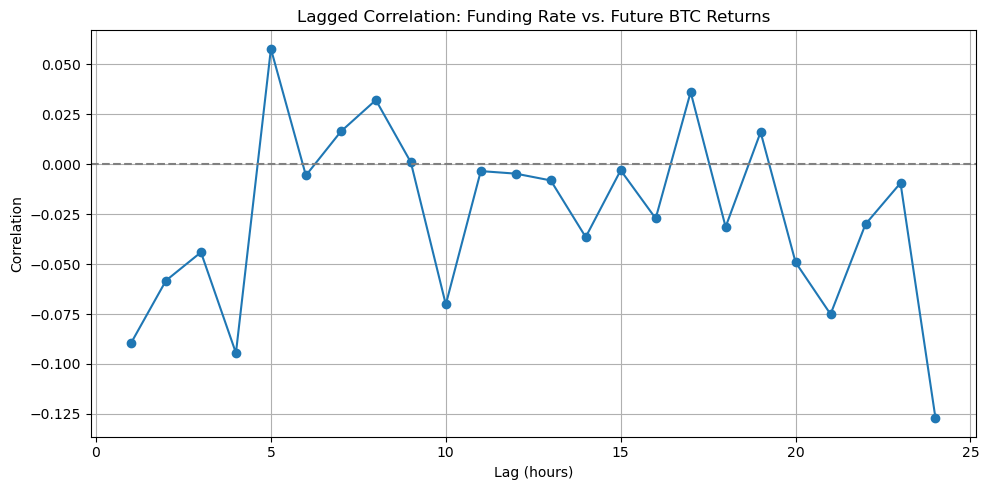

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(lagged_corr_df['Lag (h)'], lagged_corr_df['correlation'], marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Lagged Correlation: Funding Rate vs. Future BTC Returns')
plt.xlabel('Lag (hours)')
plt.ylabel('Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
window_size = 15
rolling_corr = merged_df['fundingRate'].rolling(window=window_size).corr(merged_df['btc_return'])
rolling_df = merged_df[['datetime']].copy()
rolling_df['rolling_corr'] = rolling_corr

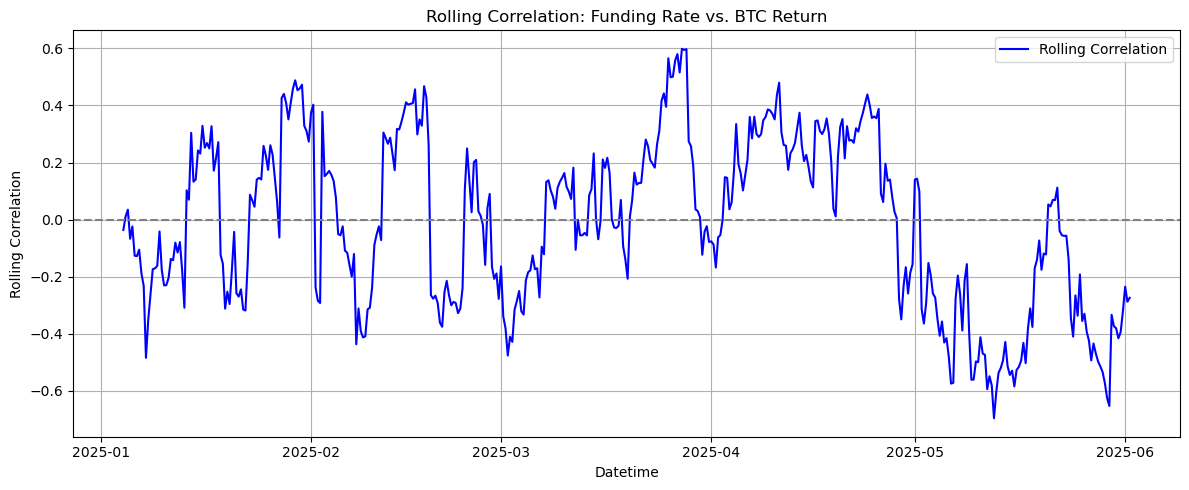

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(rolling_df['datetime'], rolling_df['rolling_corr'], label='Rolling Correlation', color='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Rolling Correlation: Funding Rate vs. BTC Return')
plt.xlabel('Datetime')
plt.ylabel('Rolling Correlation')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [10]:
import seaborn as sns


warnings.filterwarnings("ignore", category=FutureWarning)

df_gc = merged_df[['btc_return', 'fundingRate']].dropna()
gc_result = grangercausalitytests(df_gc, maxlag=6, verbose=False)

p_values = {
    lag: gc_result[lag][0]['ssr_chi2test'][1]
    for lag in gc_result.keys()
}

p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df.index.name = 'Lag (h)'
p_values_df.reset_index(inplace=True)

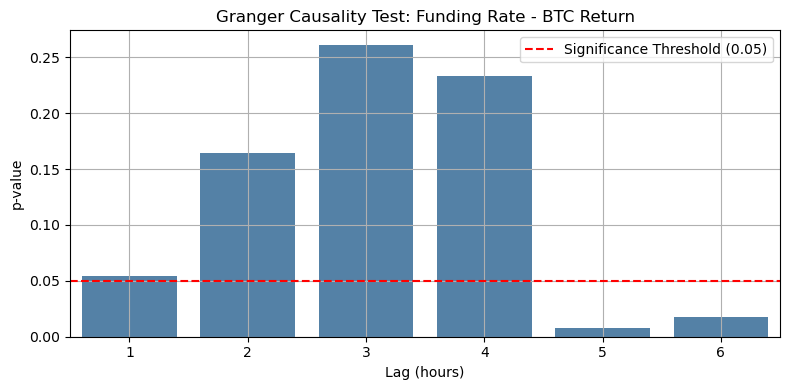

In [12]:
plt.figure(figsize=(8, 4))
sns.barplot(data=p_values_df, x='Lag (h)', y='p-value', color='steelblue')
plt.axhline(0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Granger Causality Test: Funding Rate - BTC Return')
plt.ylabel('p-value')
plt.xlabel('Lag (hours)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
high_threshold = 0.01
low_threshold = -0.005

df = merged_df.copy()
df['return_t+3'] = df['btc_return'].shift(-3)
df['return_t+6'] = df['btc_return'].shift(-6)

high_events = df[df['fundingRate'] > high_threshold]
low_events = df[df['fundingRate'] < low_threshold]

high_returns = high_events[['datetime', 'fundingRate', 'return_t+3', 'return_t+6']].copy()
low_returns = low_events[['datetime', 'fundingRate', 'return_t+3', 'return_t+6']].copy()

high_returns['event_type'] = 'high_funding'
low_returns['event_type'] = 'low_funding'

event_returns = pd.concat([high_returns, low_returns], ignore_index=True)

In [15]:
event_returns.head()

,datetime,fundingRate,return_t+3,return_t+6,event_type
0,2025-01-10 08:00:00+00:00,-0.000011,-0.001325,-0.001653,low_funding
1,2025-02-08 00:00:00+00:00,-0.000041,0.000923,0.002394,low_funding
2,2025-02-11 16:00:00+00:00,-0.000024,0.012758,-0.006195,low_funding
3,2025-02-24 00:00:00+00:00,-0.000030,0.003979,-0.006614,low_funding
4,2025-03-01 08:00:00+00:00,-0.000061,-0.005052,-0.011406,low_funding


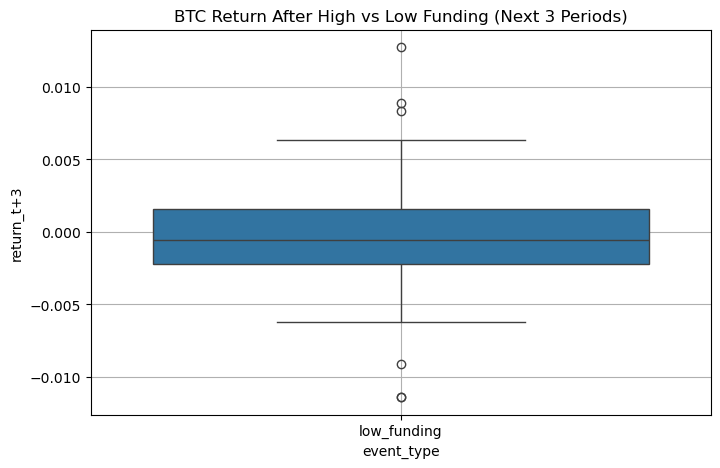

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=event_returns, x='event_type', y='return_t+3')
plt.title('BTC Return After High vs Low Funding (Next 3 Periods)')
plt.grid(True)
plt.show()

In [19]:
df[['datetime', 'btc_return', 'return_t+3']].tail(10)

,datetime,btc_return,return_t+3
2109,2025-05-29 16:00:00+00:00,-0.002241,-0.016064
2110,2025-05-30 00:00:00.003000+00:00,-0.009639,-0.000337
2111,2025-05-30 08:00:00.003000+00:00,0.002210,-0.000506
2112,2025-05-30 16:00:00+00:00,-0.016064,-0.000852
2113,2025-05-31 00:00:00+00:00,-0.000337,-0.001638
2114,2025-05-31 08:00:00+00:00,-0.000506,0.000249
2115,2025-05-31 16:00:00+00:00,-0.000852,0.002730
2116,2025-06-01 00:00:00.001000+00:00,-0.001638,NaN
2117,2025-06-01 08:00:00.002000+00:00,0.000249,NaN
2118,2025-06-01 16:00:00+00:00,0.002730,NaN


In [59]:
upper_q = df['fundingRate'].quantile(0.85)
lower_q = df['fundingRate'].quantile(0.10)

high_events = df[df['fundingRate'] > upper_q]
low_events = df[df['fundingRate'] < lower_q]

In [60]:
df['future_return_3'] = (
    df['btc_return'].shift(-1) +
    df['btc_return'].shift(-2) +
    df['btc_return'].shift(-3)
)

df['future_return_6'] = sum(df['btc_return'].shift(-i) for i in range(1, 7))

In [61]:
high_ret = df.loc[df['fundingRate'] > upper_q, ['datetime', 'fundingRate', 'future_return_3', 'future_return_6']]
low_ret = df.loc[df['fundingRate'] < lower_q, ['datetime', 'fundingRate', 'future_return_3', 'future_return_6']]

high_ret['event'] = 'high_funding'
low_ret['event'] = 'low_funding'

event_df = pd.concat([high_ret, low_ret], ignore_index=True)

In [62]:
event_df.groupby('event')[['future_return_3', 'future_return_6']].mean()

,future_return_3,future_return_6
event,,
high_funding,-0.001391,-0.000682
low_funding,0.002198,0.003028


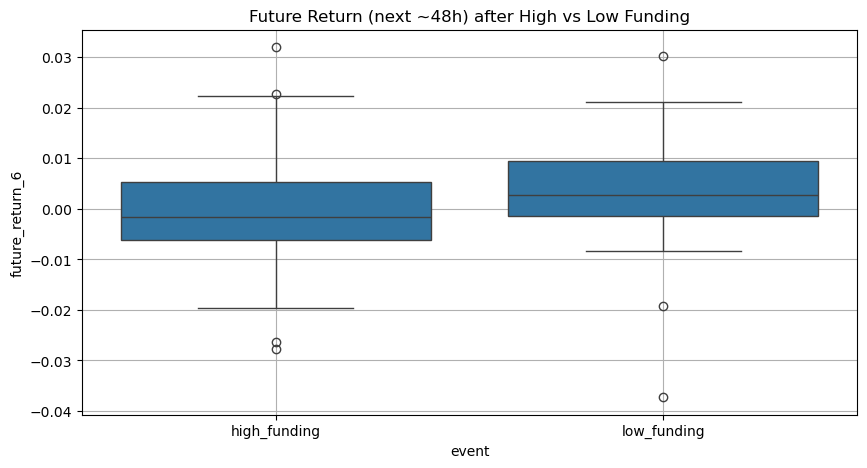

In [63]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=event_df, x='event', y='future_return_6')
plt.title('Future Return (next ~48h) after High vs Low Funding')
plt.grid(True)
plt.show()

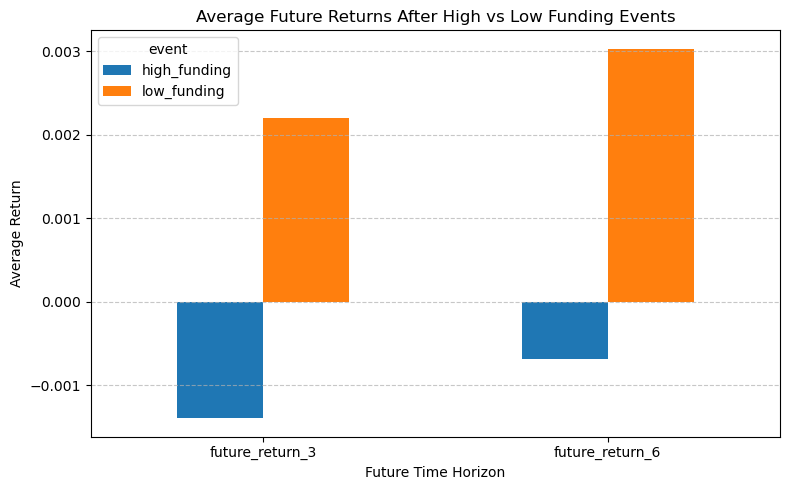

In [64]:
mean_returns = event_df.groupby('event')[['future_return_3', 'future_return_6']].mean()

mean_returns.T.plot(kind='bar', figsize=(8, 5), legend=True)
plt.title('Average Future Returns After High vs Low Funding Events')
plt.ylabel('Average Return')
plt.xlabel('Future Time Horizon')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [65]:
df['future_return_12'] = sum(df['btc_return'].shift(-i) for i in range(1, 13))
df['future_return_24'] = sum(df['btc_return'].shift(-i) for i in range(1, 25))
df['future_return_48'] = sum(df['btc_return'].shift(-i) for i in range(1, 49))

In [66]:
high_ret = df.loc[df['fundingRate'] > upper_q, ['datetime', 'fundingRate', 
    'future_return_3', 'future_return_6', 'future_return_12', 'future_return_24', 'future_return_48']]
low_ret = df.loc[df['fundingRate'] < lower_q, ['datetime', 'fundingRate', 
    'future_return_3', 'future_return_6', 'future_return_12', 'future_return_24', 'future_return_48']]

high_ret['event'] = 'high_funding'
low_ret['event'] = 'low_funding'

event_df = pd.concat([high_ret, low_ret], ignore_index=True)

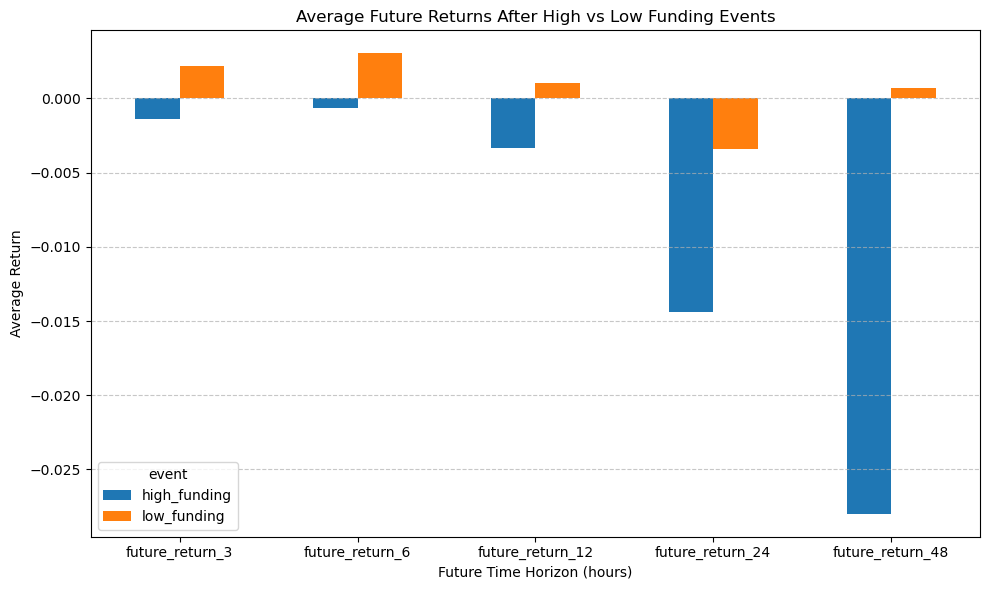

In [67]:
mean_returns = event_df.groupby('event')[
    ['future_return_3', 'future_return_6', 'future_return_12', 'future_return_24', 'future_return_48']
].mean()

mean_returns.T.plot(kind='bar', figsize=(10, 6), legend=True)
plt.title('Average Future Returns After High vs Low Funding Events')
plt.ylabel('Average Return')
plt.xlabel('Future Time Horizon (hours)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
upper_q = df['fundingRate'].quantile(0.85)
lower_q = df['fundingRate'].quantile(0.1)

high_ret = df[df['fundingRate'] > upper_q][['datetime', 'fundingRate', 'future_return_3', 'future_return_6']]
low_ret = df[df['fundingRate'] < lower_q][['datetime', 'fundingRate', 'future_return_3', 'future_return_6']]

high_ret['event'] = 'high_funding'
low_ret['event'] = 'low_funding'

event_df = pd.concat([high_ret, low_ret], ignore_index=True)

In [30]:
event_df['event'].value_counts()

event
high_funding    69
low_funding     46
Name: count, dtype: int64

In [31]:
event_df.groupby('event')[['future_return_3', 'future_return_6']].agg(['mean', 'median', 'std', 'count'])

future_return_3                           future_return_6  \
                        mean    median       std count            mean   
event                                                                    
high_funding       -0.001391 -0.001392  0.008530    69       -0.000682   
low_funding         0.002198  0.000949  0.008967    46        0.003028   

                                        
                median       std count  
event                                   
high_funding -0.001540  0.010753    69  
low_funding   0.002737  0.010397    46

In [32]:
(event_df['future_return_6'] > 0).groupby(event_df['event']).mean() * 100

event
high_funding    43.478261
low_funding     65.217391
Name: future_return_6, dtype: float64

In [33]:
merged_df[['fundingRate', 'btc_return']].corr()

,fundingRate,btc_return
fundingRate,1.000000,-0.030596
btc_return,-0.030596,1.000000


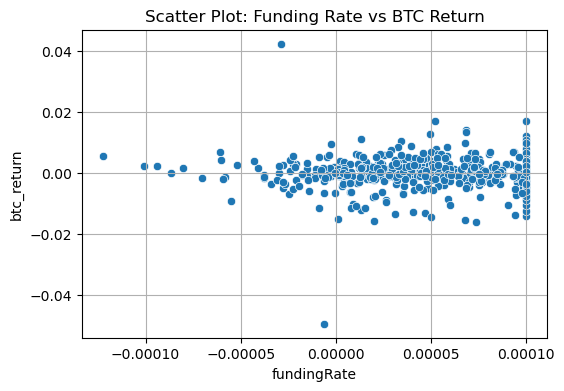

In [34]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=merged_df, x='fundingRate', y='btc_return')
plt.title('Scatter Plot: Funding Rate vs BTC Return')
plt.grid(True)
plt.show()

In [69]:
merged_df['rolling_corr_24h'].describe()

count    437.000000
mean      -0.008362
std        0.253559
min       -0.625386
25%       -0.197028
50%        0.009133
75%        0.233157
max        0.412061
Name: rolling_corr_24h, dtype: float64

In [70]:
high_threshold = merged_df['rolling_corr_24h'].quantile(0.85)
low_threshold = merged_df['rolling_corr_24h'].quantile(0.10)

high_corr_periods = merged_df[merged_df['rolling_corr_24h'] > high_threshold]
low_corr_periods = merged_df[merged_df['rolling_corr_24h'] < low_threshold]

In [71]:
print("High Corr Rolling > ", high_threshold)
print(high_corr_periods['btc_return'].describe())

print("Low Corr Rolling < ", low_threshold)
print(low_corr_periods['btc_return'].describe())

High Corr Rolling >  0.2897186129807985
count    66.000000
mean      0.000240
std       0.005228
min      -0.015150
25%      -0.001914
50%       0.000296
75%       0.002065
max       0.016951
Name: btc_return, dtype: float64
Low Corr Rolling <  -0.3455963567890535
count    44.000000
mean      0.001094
std       0.007232
min      -0.009639
25%      -0.001793
50%      -0.000083
75%       0.002636
max       0.042222
Name: btc_return, dtype: float64


In [76]:
window_size = 24

df['rolling_corr_24h'] = (
    df['fundingRate']
    .rolling(window=window_size)
    .corr(df['btc_return'])
)

In [77]:
df['future_return_3'] = sum(df['btc_return'].shift(-i) for i in range(1, 4))
df['future_return_6'] = sum(df['btc_return'].shift(-i) for i in range(1, 7))
df['future_return_12'] = sum(df['btc_return'].shift(-i) for i in range(1, 13))
df['future_return_24'] = sum(df['btc_return'].shift(-i) for i in range(1, 25))
df['future_return_48'] = sum(df['btc_return'].shift(-i) for i in range(1, 49))

high_corr_threshold = df['rolling_corr_24h'].quantile(0.85)
high_corr_df = df[df['rolling_corr_24h'] > high_corr_threshold]

future_columns = ['future_return_3', 'future_return_6', 'future_return_12', 'future_return_24', 'future_return_48']
high_corr_means = high_corr_df[future_columns].mean()

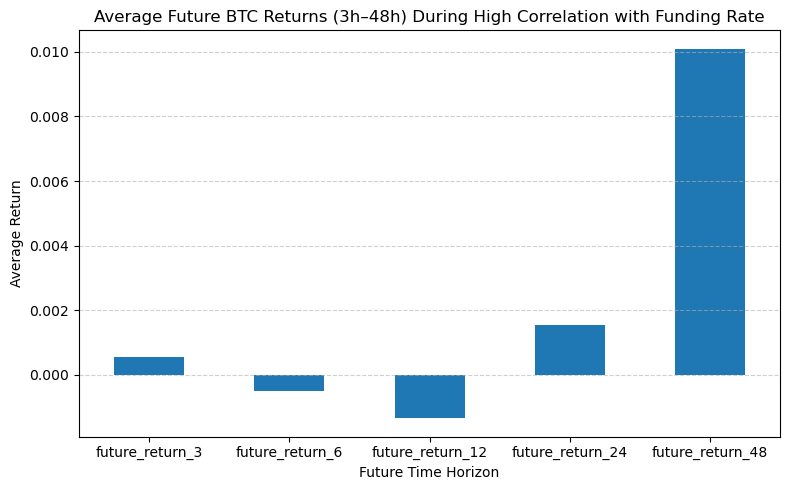

In [79]:
high_corr_means.plot(kind='bar', figsize=(8, 5))
plt.title('Average Future BTC Returns (3h–48h) During High Correlation with Funding Rate')
plt.ylabel('Average Return')
plt.xlabel('Future Time Horizon')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [80]:
merged_df['daily_return'] = merged_df['btc_return'].rolling(window=24).sum().shift(-23)


In [55]:
high_daily = merged_df[merged_df['rolling_corr_24h'] > 0.33]['daily_return']
low_daily = merged_df[merged_df['rolling_corr_24h'] < -0.35]['daily_return']

In [56]:
print("High Corr Period - Daily Return:\n", high_daily.describe())
print("\nLow Corr Period - Daily Return:\n", low_daily.describe())

High Corr Period - Daily Return:
 count    43.000000
mean     -0.001223
std       0.019617
min      -0.039531
25%      -0.017110
50%       0.001315
75%       0.011655
max       0.040386
Name: daily_return, dtype: float64

Low Corr Period - Daily Return:
 count    34.000000
mean     -0.002585
std       0.016821
min      -0.058837
25%      -0.000984
50%       0.002449
75%       0.004378
max       0.013680
Name: daily_return, dtype: float64


In [93]:
import pandas as pd

# بارگذاری فایل اصلی .pkl
data = pd.read_pickle("funding_rate_history.pkl")


In [94]:
# استخراج داده‌های BTC از بایننس
btc_data = data['binance']['BTC/USDT:USDT']

# تبدیل به DataFrame (اگر لیست از dict بود)
btc_df = pd.DataFrame(btc_data)

# نمایش نمونه‌ای از داده برای اطمینان
print(btc_df.head())


                                                info         symbol  \
0  {'symbol': 'BTCUSDT', 'fundingTime': '16877952...  BTC/USDT:USDT   
1  {'symbol': 'BTCUSDT', 'fundingTime': '16878240...  BTC/USDT:USDT   
2  {'symbol': 'BTCUSDT', 'fundingTime': '16878528...  BTC/USDT:USDT   
3  {'symbol': 'BTCUSDT', 'fundingTime': '16878816...  BTC/USDT:USDT   
4  {'symbol': 'BTCUSDT', 'fundingTime': '16879104...  BTC/USDT:USDT   

   fundingRate      timestamp                  datetime  
0       0.0001  1687795200000  2023-06-26T16:00:00.000Z  
1       0.0001  1687824000000  2023-06-27T00:00:00.000Z  
2       0.0001  1687852800000  2023-06-27T08:00:00.000Z  
3       0.0001  1687881600000  2023-06-27T16:00:00.000Z  
4       0.0001  1687910400000  2023-06-28T00:00:00.000Z  


In [95]:
btc_df = btc_df[['datetime', 'fundingRate']]


In [96]:
btc_df.to_pickle("binance_btc_funding.pkl")
